# Mixed Mode S-Parameter Conversion

When analyzing differential devices, mixed-mode S-Parameters are typically used to look at differential and common mode
characteristics. Scikit-rf provides functions to ease conversion between single ended and mixed mode S-parameters.
Nevertheless, the user must be careful to set up ports correctly and take note of the form of the mixed-mode matrix to
prevent confusion. This notebook will introduce you to the process of converting from single ended to mixed mode S
parameters using a [50 ohm calibration load](https://www.formfactor.com/download/iss-map-129-246/) as an example.
The experimental port setup consists of two differential probes as shown:

![](mixedmodebasics_files/setup.PNG)

Experimental data for the 50 ohm load taken in normal "single ended" mode will be compared against data saved in
a mixed mode format and taken using Keysight's integrated True Mode Stimulus, which applies true differential
and common mode signals during the measurement process.

In [1]:
import re
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt

sedatafile = r'mixedmodebasics_files/load_se.s4p'
mmdatafile = r'mixedmodebasics_files/load_truemode_balbal.s4p'

for file in [sedatafile, mmdatafile]:
    with open(file, encoding='cp1252') as f:
        for line in f:
            print(line.rstrip())
            if re.search('#', line):
                break
            else:
                pass
    print('\n')

!  4-Port S-parameters saved by WinCal
! VAR MeasName=S-Parameters (CALIBRATED_DATA) read from VNA (N5225A)
! VAR MeasDate=7/7/2020 2:51:53 PM
! VAR NAME=load_se
! VAR FILENAME=load_se.S4P
! VAR DATE=7/7/2020 2:51:53 PM
! VAR PHYS_PORTS=1,2,3,4
!
# Hz S RI R 50


!Agilent Technologies,N5225A,MY51451011,A.09.90.21
!Agilent N5225A: A.09.90.21
!Date: Tuesday, July 07, 2020 17:08:48
!Correction: Sdd11(Full 4 Port(1,2,3,4))
!Sdc11(Full 4 Port(1,2,3,4))
!Sdd12(Full 4 Port(1,2,3,4))
!Sdc12(Full 4 Port(1,2,3,4))
!Scd11(Full 4 Port(1,2,3,4))
!Scc11(Full 4 Port(1,2,3,4))
!Scd12(Full 4 Port(1,2,3,4))
!Scc12(Full 4 Port(1,2,3,4))
!Sdd21(Full 4 Port(1,2,3,4))
!Sdc21(Full 4 Port(1,2,3,4))
!Sdd22(Full 4 Port(1,2,3,4))
!Sdc22(Full 4 Port(1,2,3,4))
!Scd21(Full 4 Port(1,2,3,4))
!Scc21(Full 4 Port(1,2,3,4))
!Scd22(Full 4 Port(1,2,3,4))
!Scc22(Full 4 Port(1,2,3,4))
!Balanced Topology: BBAL
!S4P File: Measurements: <Sdd11,Sdc11,Sdd12,Sdc12>,
!<Scd11,Scc11,Scd12,Scc12>,
!<Sdd21,Sdc21,Sdd22,Sdc22>,
!<Scd21,S

The header data for the mixed mode data indicates that it is saved in the following format:

$$
\begin{bmatrix}
\begin{bmatrix}
    S_{dd} & S_{dc} \\
    S_{cd} & S_{cc}
\end{bmatrix}_{11} &
\begin{bmatrix}
    S_{dd} & S_{dc} \\
    S_{cd} & S_{cc}
\end{bmatrix}_{12} \\
\begin{bmatrix}
    S_{dd} & S_{dc} \\
    S_{cd} & S_{cc}
\end{bmatrix}_{21} &
\begin{bmatrix}
    S_{dd} & S_{dc} \\
    S_{cd} & S_{cc}
\end{bmatrix}_{22}
\end{bmatrix}
$$

It is important to keep this in mind, as this format may vary between different software and hardware.
For instance, skrf will transform singled ended data to the following form when two balanced ports are present:

$$
\begin{bmatrix}
\begin{bmatrix}
    S_{11} & S_{12} \\
    S_{21} & S_{22}
\end{bmatrix}_{dd} &
\begin{bmatrix}
    S_{11} & S_{12} \\
    S_{21} & S_{22}
\end{bmatrix}_{dc} \\
\begin{bmatrix}
    S_{11} & S_{12} \\
    S_{21} & S_{22}
\end{bmatrix}_{cd} &
\begin{bmatrix}
    S_{11} & S_{12} \\
    S_{21} & S_{22}
\end{bmatrix}_{cc}
\end{bmatrix}
$$

To transform our single ended data, we must first pair the ports as they existed during the experimental setup with
ports 1 and 3 making up one balanced port, and 2 and 4 on the other probe. We can than use the `se2gmm()` method of the
skrf.Network class to transform to a mixed mode s-parameter matrix, with the `p` parameter used to specify the number of
mixed mode ports. Skrf will transform the ports in pairs starting at the lowest number ports (1 and 3 after our
renumbering) and continue until the matrix contains `p` mixed mode ports, leaving the remaining ports as single ended.

In [2]:
sedata = rf.Network(sedatafile)
sedata.renumber([0, 1, 2, 3], [0, 2, 1, 3])  # pair ports as 1,3 and 2,4 to match experimental setup
sedata.se2gmm(p=2)  # two balanced ports
# sedata now in form  Sdd  Sdc with each submatrix as S11 S12
#                     Scd  Scc                        S21 S22

The following function converts a two-port balanced-balanced network in the skrf format into the format used by
Keysight to make data comparisons easier:

In [3]:
def gmm_reorder(m):
    """
    Reorders data from form 11 12 with each submatrix as dd dc
                            21 22                        cd cc
    to form dd dc with each submatrix as 11 12
            cd cc                        21 22
    """
    b = np.array([1, 0, 0, 0,
                  0, 0, 1, 0,
                  0, 1, 0, 0,
                  0, 0, 0, 1]).reshape(4, 4)
    m = b.dot(m.dot(b))
    return m

mmdata = rf.Network(mmdatafile)
# raw data is mmdata in form S11 S12 with each submatrix as dd dc
#                            S21 S22                        cd cc
for i, freq in enumerate(mmdata.f):
    mmdata.s[i, :, :] = gmm_reorder(mmdata.s[i, :, :])

Now that the two networks are in the same format, we can see that skrf does not consider them equal.
This is because the networks are not identical, they are merely two measurements of the same device, both with
experimental noise and variation. 
If the tolerances of the comparison are relaxed, the comparison of the networks returns True:

In [4]:
print(sedata == mmdata) # uses np.allclose with tight tolerances
print(np.allclose(abs(sedata.s), abs(mmdata.s), rtol=1, atol=1e-3)) # relaxed tolerances

False
True


Plotted, the error looks like this:

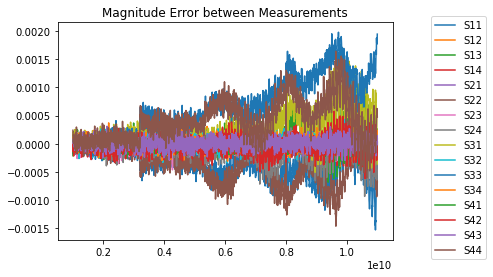

In [5]:
for m in range(4):
    for n in range(4):
        plt.plot(sedata.f, abs(mmdata.s)[:,m,n]-abs(sedata.s)[:,m,n], label=f'S{m+1}{n+1}')
        plt.title('Magnitude Error between Measurements')
        plt.legend(bbox_to_anchor=(1.1, 1.05))



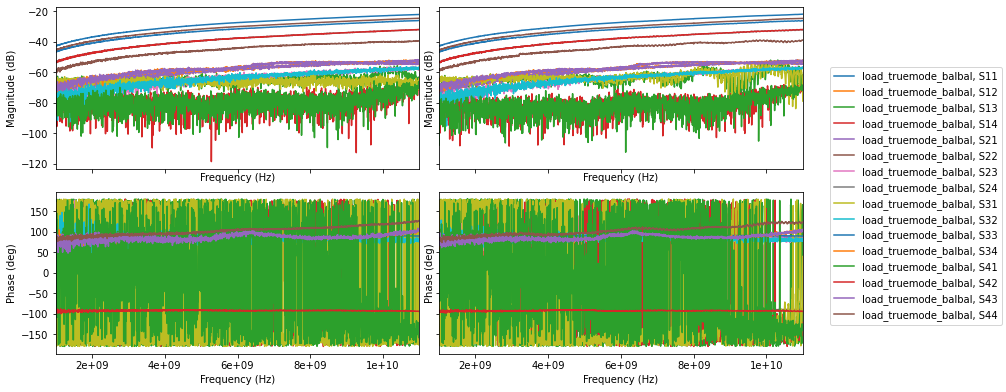

In [6]:
fig, axes = plt.subplots(2,2, sharex=True, sharey='row', figsize=(14,6))
sedata.plot_s_db(ax=axes[0][0])
mmdata.plot_s_db(ax=axes[0][1])
sedata.plot_s_deg(ax=axes[1][0])
mmdata.plot_s_deg(ax=axes[1][1])
axes[0][0].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[0][1].get_legend().remove()

fig.legend(*axes[0, 1].get_legend_handles_labels(), loc="center right")
fig.tight_layout()
plt.subplots_adjust(top=0.9, right=0.8)



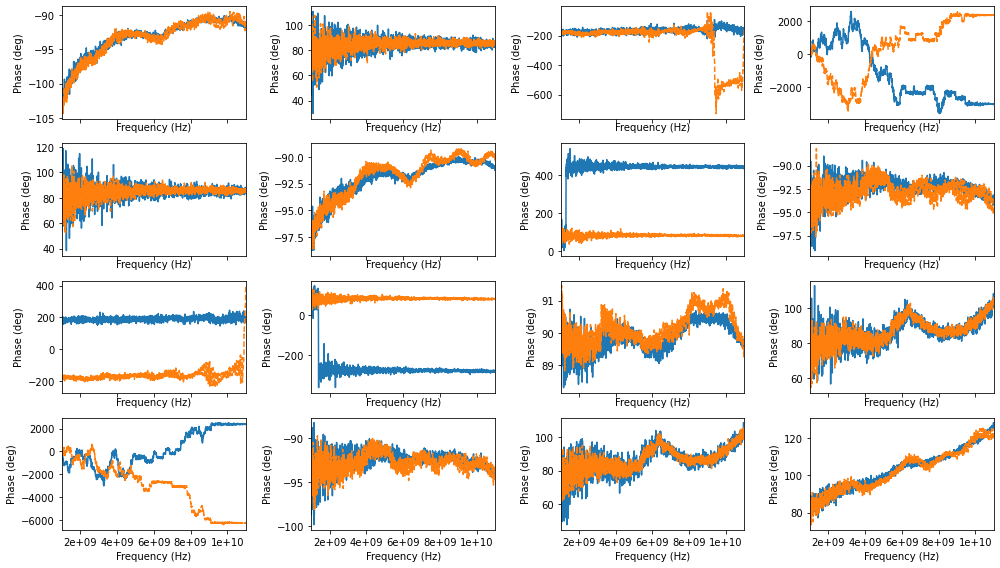

In [7]:
fig, axes = plt.subplots(4,4, sharex=True, figsize=(14,8))
for m in range(4):
    for n in range(4):
        sedata.plot_s_deg_unwrap(m=m, n=n, ax=axes[m][n])
        mmdata.plot_s_deg_unwrap(m=m, n=n, ax=axes[m][n], ls='--')
        axes[m][n].get_legend().remove()
fig.tight_layout()